# Plot monthly time spent for a recurring event from a Google calendar

use the data manually exported from google calendar into ics, then manually converted to csv

ICS to CSV converter: https://github.com/johnyluyte/ICS-to-Excel-CSV

In [1]:
import pandas as pd
import numpy as np
import datetime
# import time

# import matplotlib.pyplot as plt
import plotly.graph_objects as go
# from plotly import tools
# import plotly.offline as py
# import plotly.express as px
from plotly.offline import iplot

# %matplotlib inline





In [28]:
#import data
timetable = pd.read_csv("google_calendar.csv", usecols=("开始", "结束","标题"))
#drop all other entries except for the EVENT
EVENTNAME = "event"
timetable = timetable.loc[lambda x: (timetable['标题'] == EVENTNAME), :] #edit the desired event name
timetable = timetable.reset_index(drop=True)
timetable.tail()

,开始,结束,标题
62,20210630T101000Z,20210630T111000Z,event
63,20210630T112000Z,20210630T122000Z,event
64,20210701T112000Z,20210701T122000Z,event
65,20210703T030000Z,20210703T040000Z,event
66,20210703T003000Z,20210703T013000Z,event


In [23]:
# testing date time conversion
# print(time.mktime(datetime.datetime.strptime(timetable["开始"][8][:8], "%Y%m%d").timetuple()))
# print(datetime.datetime.strptime(timetable["开始"][8][:8]+timetable["开始"][8][-7:-1], "%Y%m%d%H%M%S"))

In [24]:
timetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   开始      67 non-null     object
 1   结束      67 non-null     object
 2   标题      67 non-null     object
dtypes: object(3)
memory usage: 1.7+ KB


In [29]:
#convert string into date
print(f'before:{timetable["开始"][0]}')
timetable["开始"] = timetable["开始"].apply(lambda x: datetime.datetime.strptime(x[:8]+x[-7:-1], "%Y%m%d%H%M%S").replace(tzinfo=datetime.timezone.utc).astimezone(tz=None))
print(f'after:{timetable["开始"][0]}')
timetable["结束"] = timetable["结束"].apply(lambda x: datetime.datetime.strptime(x[:8]+x[-7:-1], "%Y%m%d%H%M%S").replace(tzinfo=datetime.timezone.utc).astimezone(tz=None))
timetable.info()

before:20210324T092000Z
after:2021-03-24 17:20:00+08:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   开始      67 non-null     datetime64[ns, CST]
 1   结束      67 non-null     datetime64[ns, CST]
 2   标题      67 non-null     object             
dtypes: datetime64[ns, CST](2), object(1)
memory usage: 1.7+ KB


In [37]:
#calculate event duration
timetable["duration"] = None
timetable["duration"] = timetable.apply(lambda x: (x["结束"]-x["开始"]).seconds/60/60, axis=1)
#make columns for parts of the date separately (needed for use in lambda function later)
timetable["day"] = None
timetable["day"] = timetable.apply(lambda x: x["结束"].date(), axis=1)#make yyyy-mm-dd
timetable["day"] = pd.to_datetime(timetable["day"])#convert string to date
timetable["month"] = None
timetable["month"] = timetable.apply(lambda x: x["结束"].month, axis=1)
timetable["year"] = None
timetable["year"] = timetable.apply(lambda x: x["结束"].year, axis=1)
timetable.info()
timetable.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   开始        67 non-null     datetime64[ns, CST]
 1   结束        67 non-null     datetime64[ns, CST]
 2   标题        67 non-null     object             
 3   duration  67 non-null     float64            
 4   day       67 non-null     datetime64[ns]     
 5   month     67 non-null     int64              
 6   year      67 non-null     int64              
dtypes: datetime64[ns, CST](2), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.8+ KB


,开始,结束,标题,duration,day,month,year
0,2021-03-24 17:20:00+08:00,2021-03-24 19:20:00+08:00,event,2.0,2021-03-24,3,2021


### make a table for the monthly plot

In [38]:
timetable2 = timetable[["day","month","year","标题","duration"]].copy()
timetable2 = timetable2.value_counts().reset_index(name='counts').sort_values("day")
timetable2 = timetable2.reset_index(drop=True)
timetable2.tail(1)

,day,month,year,标题,duration,counts
45,2021-07-03,7,2021,event,1.0,2


In [39]:
#calculate total hours per day
timetable2["hours_per_day"] = None
timetable2["hours_per_day"] = timetable2.apply(lambda x: x["duration"]*x["counts"], axis=1)
timetable2 = timetable2.reset_index(drop=True)
timetable2 = timetable2.sort_values(by="day")
timetable2.tail(1)

,day,month,year,标题,duration,counts,hours_per_day
45,2021-07-03,7,2021,event,1.0,2,2.0


In [40]:
#check how the result of the query for a particular month looks like
timetable2.loc[lambda x: x["month"]==3,:]

,day,month,year,标题,duration,counts,hours_per_day
0,2021-03-24,3,2021,event,2.0,1,2.0
1,2021-03-28,3,2021,event,1.0,1,1.0
2,2021-03-31,3,2021,event,2.5,1,2.5


### plot monthly total

<AxesSubplot:title={'center':'hours of event per month in 2021'}, xlabel='months', ylabel='hours'>

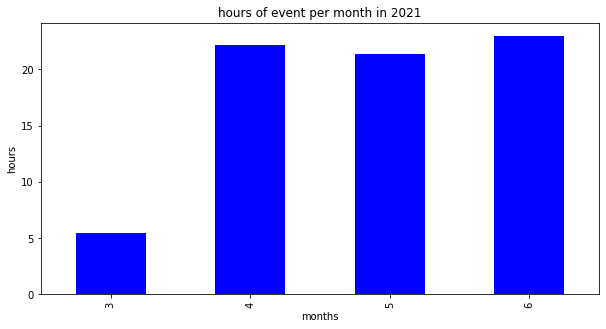

In [41]:
#plot using pandas function
year_to_report = 2021  #change this

timetable3_monthly = {}
months_in_the_year = timetable2.loc[lambda x: (timetable2['year'] == year_to_report), :]["month"].unique()
for i in range(months_in_the_year[0],months_in_the_year[-1]): #the range doesnt include the last item!
    timetable3_monthly[i] = timetable2.loc[lambda x: (timetable2['month'] == i)&(timetable2['year'] == year_to_report), :]["hours_per_day"].sum()
pd.Series(timetable3_monthly).plot(kind="bar", title=f"hours of {timetable2['标题'][0]} per month in {year_to_report}", ylabel="hours", xlabel="months", stacked=False, figsize=(10,5), colormap="winter")

In [42]:
#print out totals
pd.Series(timetable3_monthly).rename(index=("小时")).to_frame().astype(int)

,小时
3,5
4,22
5,21
6,23


In [47]:
#generate a full timeline with days for the chart, based off the table with all input data
#as it is also needed to show days without the event
date_range = None
date_range = pd.DataFrame(pd.date_range(start=timetable2['day'][:1].values[0],end=timetable2['day'][-1:].values[0]), columns=["day"])
date_range.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     102 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 944.0 bytes


total events: 23
total hours: 23


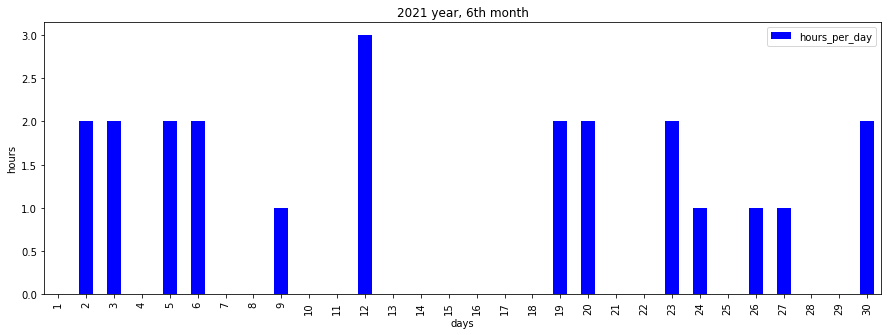

In [49]:
#plot hourly data for a given month and year using plotly
#the graph is dynamic

year_to_report = 2021  #change this
month_to_report = 6  #change this

#put the hourly data onto the timeline
events_month = timetable2.merge(date_range, on="day", how="right")

for index, row in events_month.iterrows():
    if events_month["day"][index].month != month_to_report or events_month["day"][index].year != year_to_report:
        events_month = events_month.drop(index)
events_month = events_month.reset_index(drop=True)

trace1 = go.Bar(x=events_month["day"],y=events_month["counts"], 
                text = events_month["counts"],opacity=0.75, textposition='auto')
data = [trace1]
layout = dict(title = 'event time',
              xaxis= dict(title=f'{year_to_report} year, {month_to_report}th month, days',
                          ticklen= 5,zeroline= False, tickmode = 'linear',tickangle=-45)
             )
fig = dict(data = data, layout = layout)
iplot(fig)


#plot using pandas function
#the plot is static
events_month["day"] = events_month.apply(lambda x: x["day"].day, axis=1) #replace date with int day for plot axis ticks
events_month[["day", "duration","hours_per_day"]].plot(kind="bar", x="day",y="hours_per_day", title=f'{year_to_report} year, {month_to_report}th month', ylabel="hours", xlabel="days", stacked=False, figsize=(15,5), colormap="winter")



#calculate totals
hour_sum_total = 0
events_month = events_month.dropna()
for index, row in events_month.iterrows():
    hour_sum_total+=(events_month["duration"][index]*events_month["counts"][index])
print(f'total events: {int(events_month["counts"].sum())}')
print(f'total hours: {int(hour_sum_total)}')  